In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import descartes
import datetime
import json
import operator


from scipy.stats import uniform
from dateutil.relativedelta import *
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV


import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

In [6]:
from google.colab import files
uploaded = files.upload()

Saving f1_data.csv to f1_data.csv


In [7]:
f1_d = pd.read_csv("f1_data.csv")
f1_d.head()


,year,round,grid,positionOrder,fastestLapMill,driverRef,points,driverStandingPosition,wins,constructorPoints,constructorPosition,constructorWins,qualyTime,driverAge,name_Abu Dhabi Grand Prix,name_Argentine Grand Prix,name_Australian Grand Prix,name_Austrian Grand Prix,name_Azerbaijan Grand Prix,name_Bahrain Grand Prix,name_Belgian Grand Prix,name_Brazilian Grand Prix,name_British Grand Prix,name_Canadian Grand Prix,name_Chinese Grand Prix,name_Emilia Romagna Grand Prix,name_European Grand Prix,name_French Grand Prix,name_German Grand Prix,name_Hungarian Grand Prix,name_Indian Grand Prix,name_Italian Grand Prix,name_Japanese Grand Prix,name_Korean Grand Prix,name_Malaysian Grand Prix,name_Mexican Grand Prix,name_Monaco Grand Prix,name_Portuguese Grand Prix,name_Russian Grand Prix,name_San Marino Grand Prix,name_Singapore Grand Prix,name_Spanish Grand Prix,name_Turkish Grand Prix,name_United States Grand Prix,nationality_American,nationality_Australian,nationality_Austrian,nationality_Belgian,nationality_Brazilian,nationality_British,nationality_Canadian,nationality_Colombian,nationality_Danish,nationality_Dutch,nationality_Finnish,nationality_French,nationality_German,nationality_Italian,nationality_Japanese,nationality_Mexican,nationality_Monegasque,nationality_Polish,nationality_Portuguese,nationality_Russian,nationality_Spanish,nationality_Swedish,nationality_Swiss,nationality_Venezuelan,constructor_ags,constructor_alfa,constructor_alphatauri,constructor_alpine,constructor_arrows,constructor_aston_martin,constructor_bar,constructor_benetton,constructor_bmw_sauber,constructor_brabham,constructor_caterham,constructor_dallara,constructor_ferrari,constructor_footwork,constructor_force_india,constructor_haas,constructor_honda,constructor_hrt,constructor_jaguar,constructor_jordan,constructor_larrousse,constructor_ligier,constructor_lotus_f1,constructor_marussia,constructor_mclaren,constructor_mercedes,constructor_minardi,constructor_prost,constructor_red_bull,constructor_renault,constructor_sauber,constructor_stewart,constructor_team_lotus,constructor_toro_rosso,constructor_toyota,constructor_tyrrell,constructor_williams
0,1989,1,1,11,300000.0,senna,0,11,0,6,2,0,0.0,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1989,1,2,15,300000.0,patrese,0,15,0,0,12,0,0.0,34,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,1989,1,3,25,300000.0,berger,0,24,0,9,1,1,0.0,29,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1989,1,4,23,300000.0,boutsen,0,22,0,0,12,0,0.0,31,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1989,1,5,2,300000.0,prost,6,2,0,6,2,0,0.0,34,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
#parameters dictionary  
par = {"model": [],"params":[], "score":[]}

In [9]:
# scaling data
pred_year = 2022

df = f1_d.copy()
scaler = StandardScaler()

trainSet = df[df.year != int(pred_year)]
xTrain = trainSet.drop(["driverRef", "positionOrder"], axis=1)
yTrain = trainSet.positionOrder

xTrain = pd.DataFrame(scaler.fit_transform(xTrain), columns = xTrain.columns)

In [10]:
#scoring functions
def score(model, pred_year, model_params):
    score = 0
    driversList = []
    fullPredictionDF = pd.DataFrame(columns=["results","driver","positionOrder","real","predicted"])
    
    for race in f1_d[f1_d.year == int(pred_year)]["round"].unique():
        
        #train/test
        
        testDF = f1_d[(f1_d.year == int(pred_year)) & (f1_d["round"] == race)]
        driversList = f1_d[(f1_d.year == int(pred_year)) & (f1_d["round"] == race)]["driverRef"].tolist()
        xTest = testDF.drop(["driverRef", "positionOrder"], axis=1)
        yTest = testDF.positionOrder
        
        #scaler
        xTest = pd.DataFrame(scaler.transform(xTest), columns = xTest.columns)
        
        #predictions
        predictionDF = pd.DataFrame(model.predict(xTest), columns = ["results"])
        predictionDF["driver"] = driversList
        predictionDF["positionOrder"] = yTest.reset_index(drop=True)
        predictionDF["real"] = predictionDF.positionOrder.map(lambda x: 1 if x == 1 else 0)
        predictionDF.sort_values("results", ascending = True, inplace = True)
        predictionDF.reset_index(inplace = True, drop = True)
        predictionDF["predicted"] = predictionDF.index
        predictionDF["predicted"] = predictionDF.predicted.map(lambda x:1 if x== 0 else 0)
              
        score += precision_score(predictionDF.real, predictionDF.predicted)       
        fullPredictionDF = fullPredictionDF.append(predictionDF, ignore_index=True)
                       
    totalScore = score / f1_d[f1_d.year == int(pred_year)]["round"].unique().max()
    fullPredictionDF.to_csv(f"Reggresion{model_params}.csv", index=False)
    
    return totalScore

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Regression Algorithms**



In [12]:
# LINEAR REGRESSION

params={"fit_intercept" : ["True", "False"]}

for fit_intercept in params["fit_intercept"]:
    model_params = (fit_intercept)
    model = LinearRegression(fit_intercept = fit_intercept)
    model.fit(xTrain, yTrain)
    
    string_params = ("linearRegression-" + str(fit_intercept))
    
    modelScore = score(model, pred_year, string_params)
    
    par["model"].append("linearRegression")
    par["params"].append(model_params)
    par["score"].append(modelScore)

In [13]:
# RANDOM FOREST REGRESSOR

params={"max_features": ["auto", 0.5, None],
        "n_estimators": [50, 100, 500],
        "max_depth": [5, 10, 20]}

for feature in params["max_features"]:
    for estimator in params["n_estimators"]:
        for depth in params["max_depth"]:
            model_params = (feature, estimator, depth)
            model = RandomForestRegressor(criterion = "mse", max_features = feature, n_estimators=estimator, max_depth=depth, random_state=42)
            model.fit(xTrain, yTrain)
            
            
            string_params = ("randomForest-"+str(feature), str(estimator), str(depth))
            modelScore = score(model, pred_year, string_params)
            
            par["model"].append("randomForestRegressor")
            par["params"].append(model_params)
            par["score"].append(modelScore)

**Classification Algorithms**


In [14]:
# Random Forest Classifier
params={ 'max_features': [0.8, 'auto', None],
        'criteria': ['gini', 'entropy'],        
        'max_depth': list(np.linspace(5, 55, 26)) + [None]}

for criteria in params['criteria']:
    for max_features in params['max_features']:
        for max_depth in params['max_depth']:
            model_params = (criteria, max_features, max_depth)
            model = RandomForestClassifier(criterion = criteria, max_features = max_features, max_depth = max_depth)
            model.fit(xTrain, yTrain)
            
            string_params = ("randomForest-"+str(criteria), str(max_features), str(max_depth))
            model_score = score(model, pred_year, string_params )
            
            par['model'].append('random_forest_classifier')
            par['params'].append(model_params)
            par['score'].append(model_score)

In [ ]:
# Neural network Classifier

params={'hidden_layer_sizes': [(70,10,40,5), (75,35,50,10)], 
        'activation': ['identity', 'logistic', 'tanh', 'relu'], 
        'solver': ['lbfgs', 'sgd', 'adam'], 
        'alpha': np.logspace(-4,2,20)} 

for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
        for solver in params['solver']:
            for alpha in params['alpha']:
                model_params = (hidden_layer_sizes, activation, solver, alpha )
                model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes,
                                      activation = activation, solver = solver, alpha = alpha, random_state = 1)
                model.fit(xTrain, yTrain)
                string_params = ("NNC"+ str(hidden_layer_sizes), str(activation), str(solver), str(alpha))
                model_score = score(model, pred_year, string_params )

                par['model'].append('neural_network_classifier')
                par['params'].append(model_params)
                par['score'].append(model_score)

In [17]:
data = pd.DataFrame(par).groupby("model")["score"].max()
data = data.to_frame()
idx = data.index.to_list()
data["model"] = idx

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

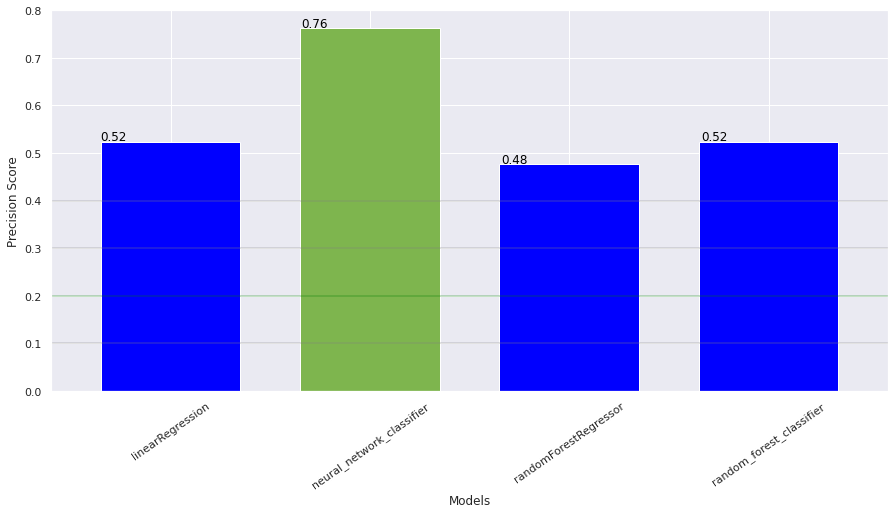

In [32]:
#plot bar chart based on Precision Score
import seaborn as sns
sns.set()
c = ['blue', '#7eb54e', 'blue', 'blue']
ax = data.plot.bar(x= "model" , y="score", width=0.7, figsize=(15,7), color = c);

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005),color='black')                   
ax.get_legend().remove()
ax.set_ylabel("Precision Score")
ax.set_xlabel("Models")
plt.axhline(y=0.1, alpha = 0.3, color = "grey");
plt.axhline(y=0.2, alpha = 0.3, color = "green");
plt.axhline(y=0.3, alpha = 0.3, color = "grey");
plt.axhline(y=0.4, alpha = 0.3, color = "grey");
plt.xticks(rotation=35)

Total 

In [37]:
result_df = pd.read_csv("/content/Reggresion('NNC(70, 10, 40, 5)', 'identity', 'adam', '0.0001').csv").head()
result_df.drop(columns=["results"])

,driver,positionOrder,real,predicted
0,leclerc,1,1,1
1,sainz,2,0,0
2,hamilton,3,0,0
3,alonso,9,0,0
4,russell,4,0,0


In [49]:
filtered_df = result_df.query('positionOrder == 1')
filtered_df

,results,driver,positionOrder,real,predicted
0,1,leclerc,1,1,1


 **Neural_network_classifier results**

In [48]:
# neural_network_classifier results for the 2022 RACE RESULTS
result_df1 = pd.read_csv("/content/Reggresion('NNC(70, 10, 40, 5)', 'identity', 'adam', '0.0001').csv")
filtered_df = result_df1.query('positionOrder == 1').drop(columns=["results"])
filtered_df

,driver,positionOrder,real,predicted
0,leclerc,1,1,1
23,max_verstappen,1,1,0
40,leclerc,1,1,1
60,max_verstappen,1,1,1
81,max_verstappen,1,1,0
101,max_verstappen,1,1,0
121,perez,1,1,0
142,max_verstappen,1,1,0
160,max_verstappen,1,1,1
182,sainz,1,1,0


In [16]:

result_df2 = pd.read_csv("/content/Reggresion('randomForest-0.5', '100', '10').csv")
rfc_filtered_df1 = result_df2.query('positionOrder == 1').drop(columns=["results"])
rfc_filtered_df1

,driver,positionOrder,real,predicted
0,leclerc,1,1,1
22,max_verstappen,1,1,0
40,leclerc,1,1,1
61,max_verstappen,1,1,0
81,max_verstappen,1,1,0
101,max_verstappen,1,1,0
121,perez,1,1,0
143,max_verstappen,1,1,0
160,max_verstappen,1,1,1
183,sainz,1,1,0


In [20]:
result_df2.drop(columns=["results"])

,driver,positionOrder,real,predicted
0,leclerc,1,1,1
1,sainz,2,0,0
2,hamilton,3,0,0
3,russell,4,0,0
4,kevin_magnussen,5,0,0
...,...,...,...,...
415,tsunoda,17,0,0
416,albon,15,0,0
417,latifi,16,0,0
418,ricciardo,20,0,0
